#### Modeling & Forecasting

This notebook builds and evaluates multiple forecasting models,
including statistical and machine learning approaches,
to predict monthly air passenger demand.


In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib

c:\DS_Projects\air-travel-demand-forecasting\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/raw/Air_Traffic_Passenger_Statistics.csv")

In [3]:
df["Passenger Count"].dtype

dtype('O')

In [4]:
df["Passenger Count"] = (
    df["Passenger Count"]
    .astype(str)
    .str.replace(",", "", regex=False)
)

df["Passenger Count"] = pd.to_numeric(
    df["Passenger Count"],
    errors="coerce"
)

df = df.dropna(subset=["Passenger Count"])

In [5]:
df["Activity Period"] = pd.to_datetime(
    df["Activity Period"],
    format="%Y%m"
)

df = df.sort_values("Activity Period")

ts = df.groupby("Activity Period")["Passenger Count"].sum().to_frame()

ts["log_passengers"] = np.log(ts["Passenger Count"])
ts["log_diff_1_seasonal"] = ts["log_passengers"].diff().diff(12)

In [6]:
final_series = ts["log_diff_1_seasonal"].dropna()

<Figure size 1400x500 with 0 Axes>

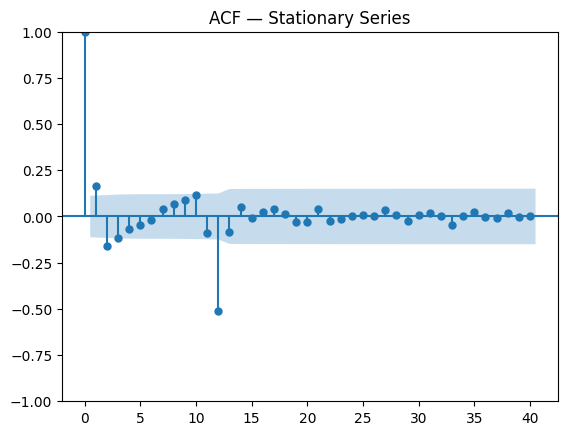

<Figure size 1400x500 with 0 Axes>

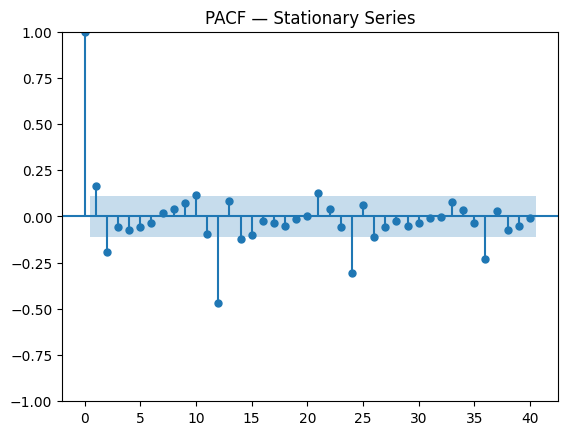

In [7]:
plt.figure(figsize=(14, 5))
plot_acf(final_series, lags=40)
plt.title("ACF — Stationary Series")
plt.show()

plt.figure(figsize=(14, 5))
plot_pacf(final_series, lags=40)
plt.title("PACF — Stationary Series")
plt.show()

The ACF plot shows a significant spike at lag 1 and a strong seasonal spike at lag 12, indicating non-seasonal MA(1) and seasonal MA(1) components. Combined with PACF analysis, this supports a SARIMA(1,1,1)(1,1,1,12) model.

In [8]:
df["Activity Period"].head()
df["Activity Period"].tail()

38778   2025-09-01
38779   2025-09-01
38780   2025-09-01
38772   2025-09-01
38892   2025-09-01
Name: Activity Period, dtype: datetime64[ns]

In [9]:
# monthly time series

ts = (
    df.groupby("Activity Period")["Passenger Count"]
    .sum()
    .asfreq("MS")
)

In [10]:
print(ts.index.min(), ts.index.max())
print(len(ts))

1999-07-01 00:00:00 2025-09-01 00:00:00
315


### SARIMA

In [11]:
# Fit SARIMA 

model = SARIMAX(
    ts,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    Passenger Count   No. Observations:                  315
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3995.785
Date:                            Thu, 01 Jan 2026   AIC                           8001.569
Time:                                    11:39:29   BIC                           8019.884
Sample:                                07-01-1999   HQIC                          8008.909
                                     - 09-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3171      0.247      1.285      0.199      -0.166       0.800
ma.L1         -0.0290      0.254   

The SARIMA(1,1,1)(1,1,1,12) model was successfully fitted to 315 monthly observations. Seasonal MA terms were highly significant, highlighting strong yearly effects in passenger demand. Diagnostic tests indicate uncorrelated residuals, though deviations from normality are observed due to structural shocks such as COVID-19.

In [12]:
# Train/Test Split

train = ts.loc[: "2019-12-01"]
test  = ts.loc["2020-01-01":]

print(len(train), len(test))

246 69


In [13]:
# Fit SARIMA on TRAIN data only

model = SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()

In [14]:
# Forecast the TEST period

forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

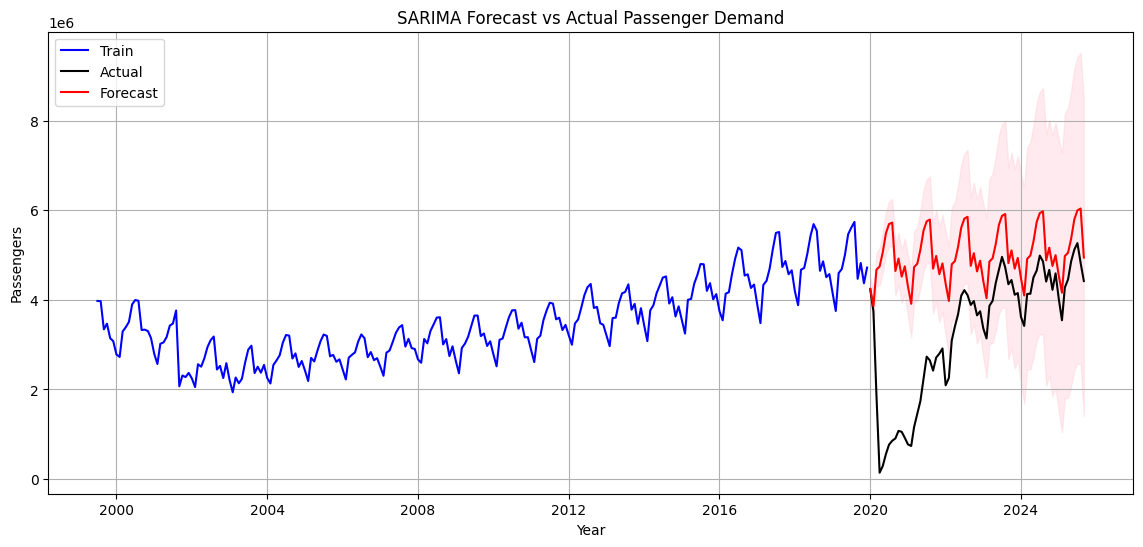

In [15]:
# Plot Forecast vs Actual

plt.figure(figsize=(14, 6))

plt.plot(train.index, train, label="Train", color="blue")
plt.plot(test.index, test, label="Actual", color="black")
plt.plot(forecast_mean.index, forecast_mean, label="Forecast", color="red")

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="pink",
    alpha=0.3
)

plt.legend()
plt.title("SARIMA Forecast vs Actual Passenger Demand")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.grid(True)
plt.show()

In [16]:
# Evaluation Metrics

mae = mean_absolute_error(test, forecast_mean)
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
mape = np.mean(np.abs((test - forecast_mean) / test)) * 100

print("MAE :", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("MAPE:", round(mape, 2), "%")

MAE : 1735134.27
RMSE: 2198799.76
MAPE: 176.92 %


### Prophet

In [17]:
# Prepare data for Prophet

prophet_train = train.reset_index()
prophet_train.columns = ["ds", "y"]

In [18]:
# Train Prophet

prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

prophet_model.fit(prophet_train)

11:39:30 - cmdstanpy - INFO - Chain [1] start processing
11:39:31 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
# Forecast Test Period

future = prophet_model.make_future_dataframe(
    periods=len(test),
    freq="MS"
)

prophet_forecast = prophet_model.predict(future)

In [20]:
# Extract forecast values

prophet_pred = prophet_forecast.set_index("ds")["yhat"].loc[test.index]

In [21]:
# Extract forecast values

mae_p = mean_absolute_error(test, prophet_pred)
rmse_p = np.sqrt(mean_squared_error(test, prophet_pred))
mape_p = np.mean(np.abs((test - prophet_pred) / test)) * 100

print("Prophet MAE:", round(mae_p, 2))
print("Prophet RMSE:", round(rmse_p, 2))
print("Prophet MAPE:", round(mape_p, 2), "%")

Prophet MAE: 2277263.86
Prophet RMSE: 2559179.78
Prophet MAPE: 198.67 %


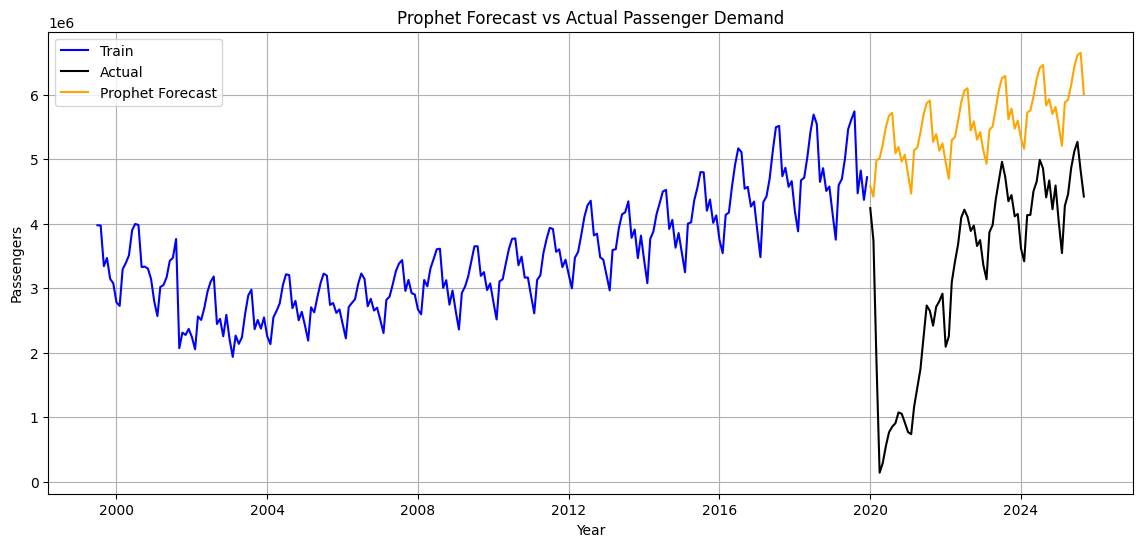

In [22]:
plt.figure(figsize=(14, 6))

# Train data
plt.plot(train.index, train, label="Train", color="blue")

# Actual test data
plt.plot(test.index, test, label="Actual", color="black")

# Prophet forecast
plt.plot(
    prophet_pred.index,
    prophet_pred,
    label="Prophet Forecast",
    color="orange"
)

plt.title("Prophet Forecast vs Actual Passenger Demand")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

### ML Regression (XGBoost or RF)

In [23]:
# Feature Engineering

df_ml = ts.reset_index()
df_ml["year"] = df_ml["Activity Period"].dt.year
df_ml["month"] = df_ml["Activity Period"].dt.month
df_ml["lag_1"] = df_ml["Passenger Count"].shift(1)
df_ml["lag_12"] = df_ml["Passenger Count"].shift(12)

df_ml.dropna(inplace=True)

In [24]:
# Train/Test for ML

X = df_ml[["year", "month", "lag_1", "lag_12"]]
y = df_ml["Passenger Count"]

X_train = X[X.index < len(train)]
X_test  = X[X.index >= len(train)]

y_train = y.iloc[:len(X_train)]
y_test  = y.iloc[len(X_train):]

In [25]:
# Train XGBoost

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [26]:
# ML Evaluation

mae_x = mean_absolute_error(y_test, xgb_pred)
rmse_x = np.sqrt(mean_squared_error(y_test, xgb_pred))
mape_x = np.mean(np.abs((y_test - xgb_pred) / y_test)) * 100

print("XGBoost MAE:", round(mae_x, 2))
print("XGBoost RMSE:", round(rmse_x, 2))
print("XGBoost MAPE:", round(mape_x, 2), "%")

XGBoost MAE: 1020220.06
XGBoost RMSE: 1723884.08
XGBoost MAPE: 147.11 %


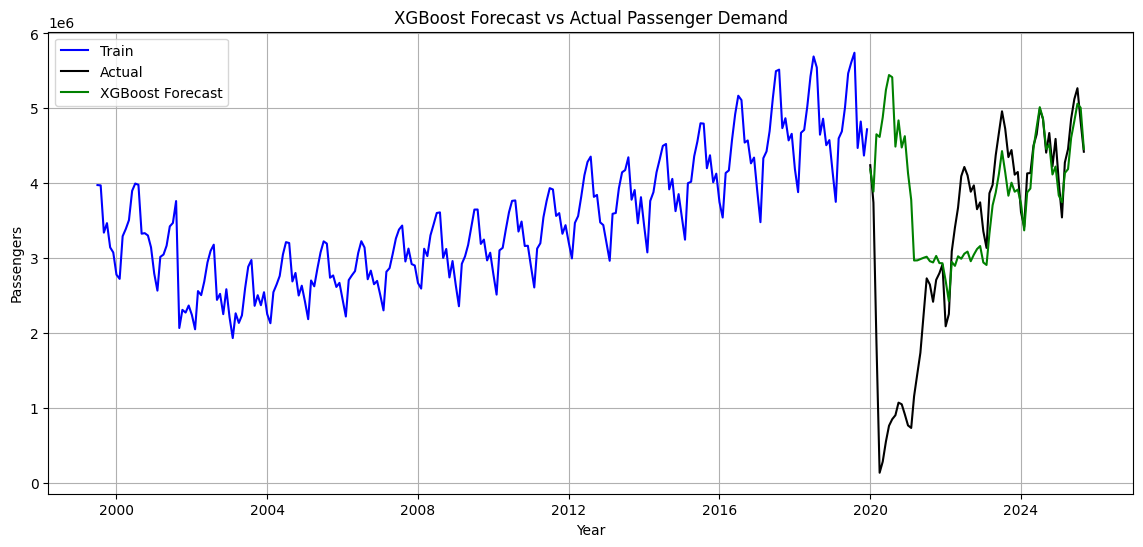

In [28]:
# XGBoost Forecast vs Actual Plot

plt.figure(figsize=(14, 6))

plt.plot(train.index, train, label="Train", color="blue")
plt.plot(test.index, test, label="Actual", color="black")
plt.plot(test.index, xgb_pred, label="XGBoost Forecast", color="green")

plt.legend()
plt.title("XGBoost Forecast vs Actual Passenger Demand")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.grid(True)
plt.show()

### LightGBM (Time-Series Regression)

In [29]:
# Reuse SAME ML Features

df_lgb = ts.reset_index()

df_lgb["year"] = df_lgb["Activity Period"].dt.year
df_lgb["month"] = df_lgb["Activity Period"].dt.month
df_lgb["lag_1"] = df_lgb["Passenger Count"].shift(1)
df_lgb["lag_12"] = df_lgb["Passenger Count"].shift(12)

df_lgb.dropna(inplace=True)

In [30]:
# Train/Test Split (Time-aware)

X = df_lgb[["year", "month", "lag_1", "lag_12"]]
y = df_lgb["Passenger Count"]

split_idx = len(train) - 12

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

In [31]:
# Train LightGBM Model

lgb_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 234, number of used features: 4
[LightGBM] [Info] Start training from score 3484277.269231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,6
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [32]:
# Predict

lgb_pred = lgb_model.predict(X_test)

In [33]:
# Evaluation

mae_lgb = mean_absolute_error(y_test, lgb_pred)
rmse_lgb = np.sqrt(mean_squared_error(y_test, lgb_pred))
mape_lgb = np.mean(np.abs((y_test - lgb_pred) / y_test)) * 100

print("LightGBM MAE:", round(mae_lgb, 2))
print("LightGBM RMSE:", round(rmse_lgb, 2))
print("LightGBM MAPE:", round(mape_lgb, 2), "%")

LightGBM MAE: 857786.5
LightGBM RMSE: 1497233.96
LightGBM MAPE: 130.8 %


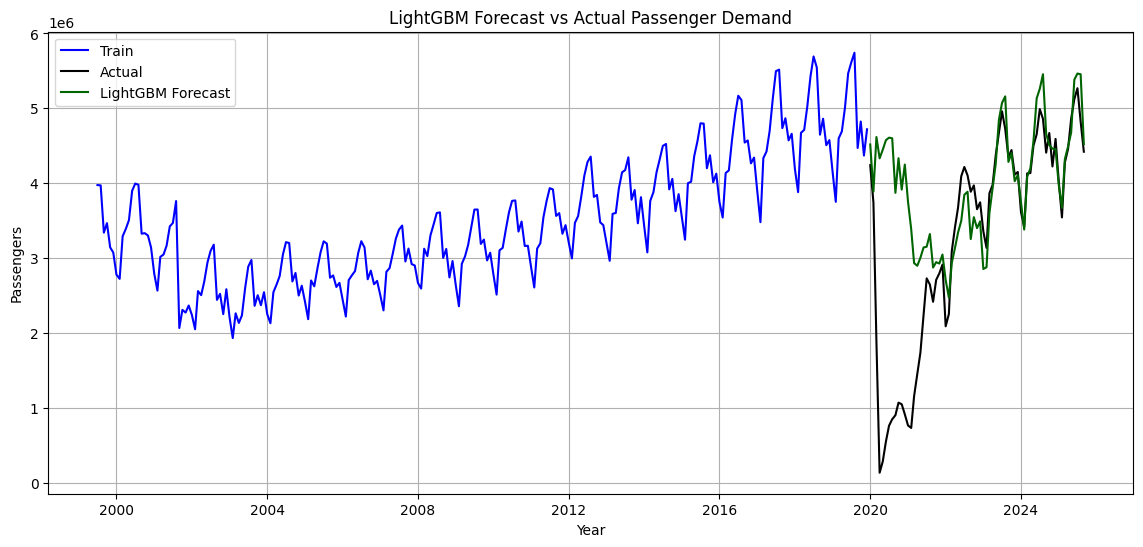

In [34]:
# LightGBM Forecast vs Actual Plot

plt.figure(figsize=(14, 6))

plt.plot(train.index, train, label="Train", color="blue")
plt.plot(test.index, test, label="Actual", color="black")
plt.plot(test.index, lgb_pred, label="LightGBM Forecast", color="darkgreen")

plt.title("LightGBM Forecast vs Actual Passenger Demand")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Final Comparison Table

comparison = pd.DataFrame({
    "Model": ["SARIMA", "Prophet", "XGBoost", "LightGBM"],
    "MAE": [mae, mae_p, mae_x, mae_lgb],
    "RMSE": [rmse, rmse_p, rmse_x, rmse_lgb],
    "MAPE (%)": [mape, mape_p, mape_x, mape_lgb]
})

comparison

,Model,MAE,RMSE,MAPE (%)
0,SARIMA,1.735134e+06,2.198800e+06,176.922256
1,Prophet,2.277264e+06,2.559180e+06,198.667826
2,XGBoost,1.020220e+06,1.723884e+06,147.105453
3,LightGBM,8.577865e+05,1.497234e+06,130.801132


Among all evaluated models, LightGBM achieved the best forecasting performance across all error metrics. This highlights the advantage of gradient boosting models with lag-based features in handling non-linear patterns and structural breaks in time-series data.

In [36]:
# Save Lightgbm Model 

joblib.dump(lgb_model, "../models/lightgbm_model.pkl")

['../models/lightgbm_model.pkl']

In [38]:
# Create final_timeseries.csv

ts_df = ts.reset_index()
ts_df.to_csv("../data/processed/final_timeseries.csv", index=False)